# **TUIA - Aprendizaje Automático 1 - 2024**

---

**Materia:** Aprendizaje Automático I (IA41)

**Año académico:** 2024

**Período lectivo:** 2° cuatrimestre

**Integrantes:**
- Britos, Julián Francisco
- Menescaldi, Brisa
- Rodriguez y Barros, Francisco 

# Librerías

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Carga de datos

In [2]:
weatherdata = pd.read_csv('weatherAUS.csv')

# Selección aleatoria de 10 ciudades

In [3]:
# Seleccionamos aleatoriamente 10 ciudades de la columna Location usando una semilla fija
cities = weatherdata['Location'].sample(10, random_state=0)
cities

138175     AliceSprings
38638        WaggaWagga
124058       SalmonGums
99214          Adelaide
25097           Penrith
116391       PearceRAAF
21742     NorfolkIsland
32587            Sydney
111239           Albany
122798            Perth
Name: Location, dtype: object

In [4]:
# Eliminamos todas las ciudades que no sean las pre-selecionadas en la lista cities
weatherdata = weatherdata[weatherdata['Location'].isin(cities)]

# Eliminamos la columna Location ya que para este trabajo consideramos todas las locaciones como una misma
weatherdata = weatherdata.drop(columns='Location')

# Exploración de los datos

Examinaremos los datos para un primer vistazo.

In [5]:
weatherdata

,Date,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
21119,2009-01-01,20.4,25.8,0.0,6.0,12.4,NNW,31.0,NNW,NW,...,84.0,71.0,1014.5,1013.6,3.0,1.0,23.3,24.7,No,No
21120,2009-01-02,20.9,26.7,0.2,8.0,10.3,N,31.0,NNE,NE,...,79.0,77.0,1016.3,1015.5,2.0,5.0,25.0,25.1,No,No
21121,2009-01-03,22.3,26.3,0.0,3.2,2.0,E,35.0,ENE,SE,...,87.0,90.0,1014.6,1014.3,7.0,7.0,24.7,23.8,No,Yes
21122,2009-01-04,21.6,22.2,1.2,2.8,0.0,ESE,41.0,ESE,ESE,...,92.0,95.0,1016.0,1015.3,8.0,8.0,22.1,21.2,Yes,Yes
21123,2009-01-05,20.4,23.5,2.6,2.2,2.9,ESE,52.0,ESE,ESE,...,86.0,86.0,1015.3,1013.7,7.0,7.0,21.8,21.6,Yes,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139106,2017-06-21,1.6,23.1,0.0,NaN,NaN,ESE,30.0,NaN,SE,...,50.0,26.0,1024.9,1020.5,NaN,NaN,11.3,22.8,No,No
139107,2017-06-22,2.9,25.6,0.0,NaN,NaN,E,26.0,NaN,SE,...,53.0,23.0,1023.9,1019.4,NaN,NaN,11.6,25.1,No,No
139108,2017-06-23,4.1,27.8,0.0,NaN,NaN,N,19.0,NE,N,...,45.0,18.0,1021.4,1017.3,NaN,NaN,15.1,27.2,No,No
139109,2017-06-24,5.0,27.9,0.0,NaN,NaN,SSE,20.0,NaN,WSW,...,35.0,16.0,1019.2,1016.4,NaN,NaN,15.4,27.1,No,No


Hay demaciadas columnas y no se llegan a apreciar todas

In [6]:
weatherdata.columns

Index(['Date', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'RainTomorrow'],
      dtype='object')

Obtenemos informacion general del dataset

In [7]:
weatherdata.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30877 entries, 21119 to 139110
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           30877 non-null  object 
 1   MinTemp        30715 non-null  float64
 2   MaxTemp        30728 non-null  float64
 3   Rainfall       30290 non-null  float64
 4   Evaporation    19410 non-null  float64
 5   Sunshine       21474 non-null  float64
 6   WindGustDir    26350 non-null  object 
 7   WindGustSpeed  26351 non-null  float64
 8   WindDir9am     29037 non-null  object 
 9   WindDir3pm     29835 non-null  object 
 10  WindSpeed9am   30641 non-null  float64
 11  WindSpeed3pm   29991 non-null  float64
 12  Humidity9am    30636 non-null  float64
 13  Humidity3pm    29996 non-null  float64
 14  Pressure9am    24752 non-null  float64
 15  Pressure3pm    24752 non-null  float64
 16  Cloud9am       19370 non-null  float64
 17  Cloud3pm       18643 non-null  float64
 18  Temp9a

El dataset cuenta con 30877 registros, es decir, filas.

Solamente `Date` tiene todos sus valores completos, ya que en cada una el conteo de valores no nulos de las demas caracteristicas es menor que el total.

In [8]:
# Valores faltantes en el dataset
weatherdata.isnull().sum()

Date                 0
MinTemp            162
MaxTemp            149
Rainfall           587
Evaporation      11467
Sunshine          9403
WindGustDir       4527
WindGustSpeed     4526
WindDir9am        1840
WindDir3pm        1042
WindSpeed9am       236
WindSpeed3pm       886
Humidity9am        241
Humidity3pm        881
Pressure9am       6125
Pressure3pm       6125
Cloud9am         11507
Cloud3pm         12234
Temp9am            147
Temp3pm            807
RainToday          587
RainTomorrow       589
dtype: int64

In [9]:
weatherdata.describe(include='all')

,Date,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
count,30877,30715.000000,30728.000000,30290.000000,19410.000000,21474.000000,26350,26351.000000,29037,29835,...,30636.000000,29996.00000,24752.000000,24752.000000,19370.000000,18643.000000,30730.000000,30070.000000,30290,30288
unique,3344,NaN,NaN,NaN,NaN,NaN,16,NaN,16,16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,2
top,2009-01-01,NaN,NaN,NaN,NaN,NaN,E,NaN,E,SW,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,No
freq,10,NaN,NaN,NaN,NaN,NaN,2458,NaN,3222,2850,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23917,23917
mean,NaN,12.743708,24.013148,1.980865,5.663776,8.014562,NaN,38.525065,NaN,NaN,...,64.273796,47.62805,1017.957999,1015.564564,4.066391,4.102451,17.850088,22.656751,NaN,NaN
std,NaN,5.700223,6.569885,6.577661,4.131155,3.756950,NaN,12.460749,NaN,NaN,...,20.212237,21.22657,6.745881,6.644922,2.880685,2.717290,5.716287,6.435339,NaN,NaN
min,NaN,-5.200000,6.300000,0.000000,0.000000,0.000000,NaN,7.000000,NaN,NaN,...,1.000000,1.00000,980.500000,979.000000,0.000000,0.000000,0.000000,6.000000,NaN,NaN
25%,NaN,8.800000,19.100000,0.000000,2.800000,5.500000,NaN,30.000000,NaN,NaN,...,52.000000,31.00000,1013.400000,1011.000000,1.000000,1.000000,13.700000,17.900000,NaN,NaN
50%,NaN,13.100000,22.900000,0.000000,4.800000,9.000000,NaN,37.000000,NaN,NaN,...,66.000000,48.00000,1018.000000,1015.600000,4.000000,4.000000,17.800000,21.600000,NaN,NaN
75%,NaN,17.000000,28.000000,0.600000,7.600000,10.900000,NaN,46.000000,NaN,NaN,...,80.000000,63.00000,1022.600000,1020.100000,7.000000,7.000000,21.600000,26.500000,NaN,NaN


Vemos que hay algunas columnas que puede que tengan outlier como `Evaporation` o `WindGustSpeed`

# Visualización de los datos

## Matriz de correlación de variable continuas

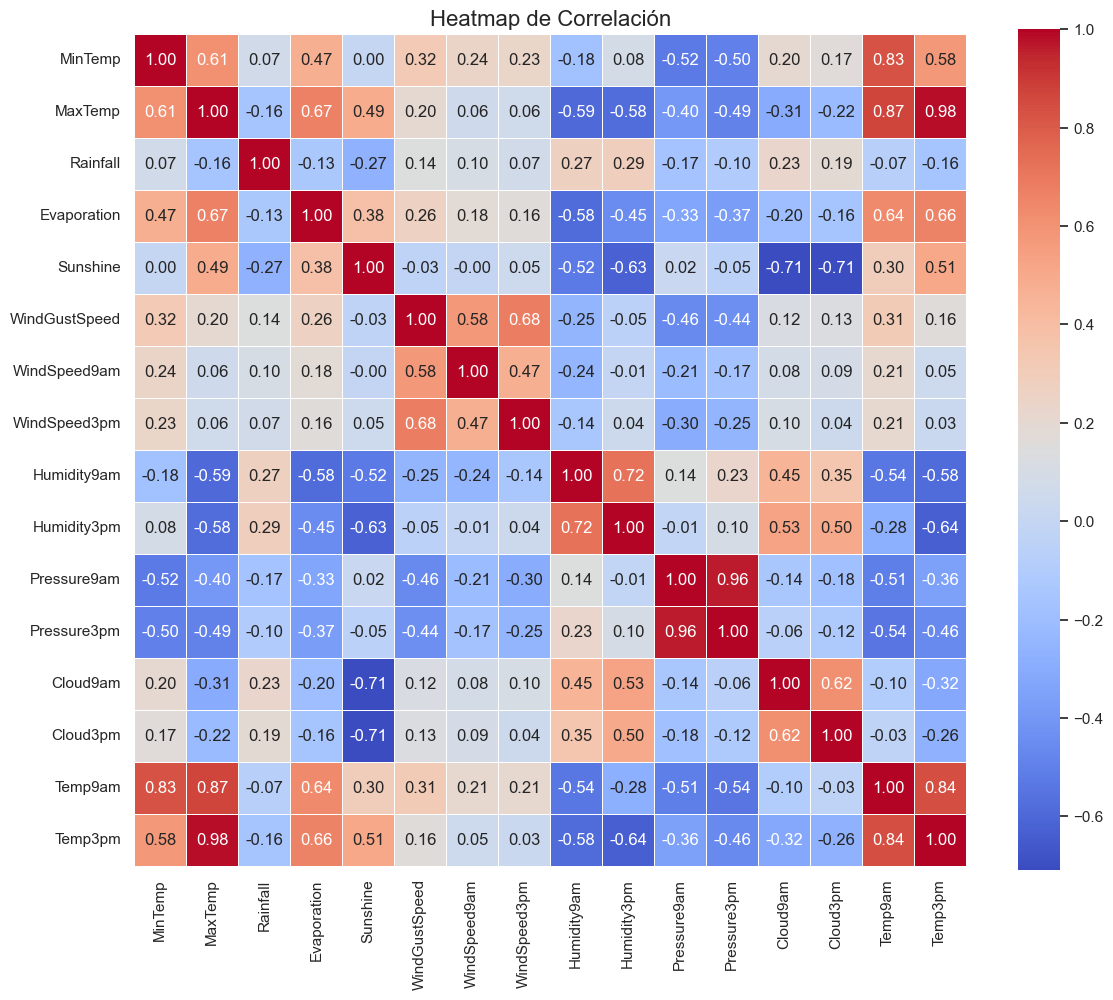

In [10]:
variables = ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 
       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 
       'Temp9am', 'Temp3pm']

weatherdata_subset = weatherdata[variables]

# Calcular la correlación entre las variables
correlation = weatherdata_subset.corr()

sns.set_theme()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation, annot=True, cmap='coolwarm', linewidths=0.5, fmt='.2f', square=True)
plt.title('Heatmap de Correlación', fontsize=16)
plt.tight_layout()
plt.show()

### Análisis de correlación entre variables

##### Correlaciones altas identificadas (≥ 0.70):

1. **MaxTemp y Temp3pm** (0.98):
   - Existe una correlación positiva extremadamente fuerte entre la temperatura máxima del día y la temperatura a las 3pm.
   - Esto sugiere que la temperatura máxima diaria típicamente ocurre cerca de las 3pm, lo cual es consistente con el ciclo diario normal de temperatura.

2. **Pressure9am y Pressure3pm** (0.96):
   - Hay una correlación positiva muy fuerte entre la presión atmosférica medida a las 9am y a las 3pm.
   - Indica que los cambios de presión atmosférica son graduales y mantienen una consistencia a lo largo del día.

3. **Temp9am y MaxTemp** (0.87):
   - Se observa una fuerte correlación positiva entre la temperatura de la mañana y la temperatura máxima del día.
   - Esto podría ser útil para predicciones tempranas de las temperaturas máximas diarias.

4. **Temp9am y Temp3pm** (0.84):
   - La correlación positiva fuerte entre las temperaturas de la mañana y la tarde indica un patrón predecible en el ciclo diario de temperatura.

5. **Humidity9am y Humidity3pm** (0.72):
   - La humedad relativa muestra una correlación positiva fuerte entre las mediciones de la mañana y la tarde.
   - Sugiere cierta estabilidad en los niveles de humedad durante el día.

##### Correlaciones negativas significativas:

1. **Cloud9am/Cloud3pm y Sunshine** (-0.71):
   - La fuerte correlación negativa entre la nubosidad y las horas de sol es lógica y esperada.
   - Confirma que la cobertura nubosa es un factor determinante en la cantidad de luz solar recibida.

##### Nota

Realizaremos las siguientes visualizaciones de aquellas variables cuya correlación sea alta para ver cómo se comportan juntas de una forma más gráfica, ya que estos valores "altos" que nos dieron solo nos indican la fuerza y dirección de la relación lineal entre las variables, pero no nos muestran la forma exacta de la relación (podría ser no lineal).

## MinTemp y Temp9am

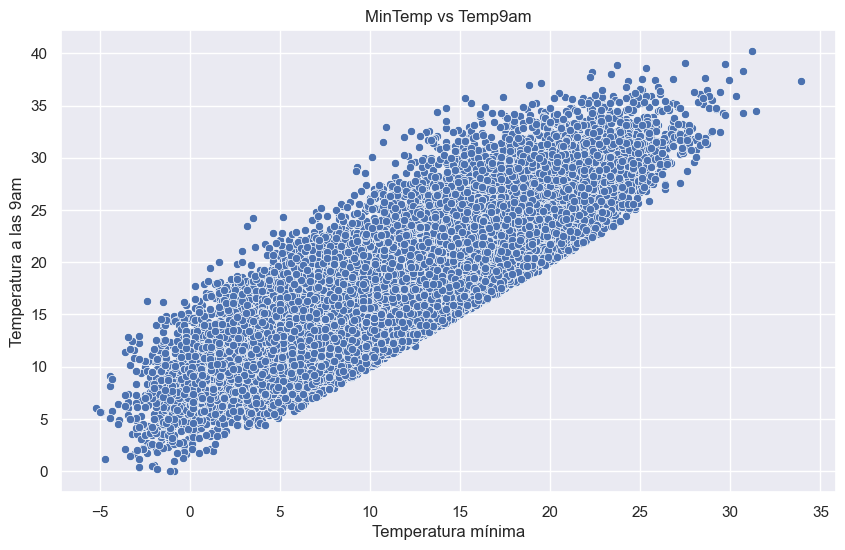

In [11]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=weatherdata, x='MinTemp', y='Temp9am')
plt.title('MinTemp vs Temp9am')
plt.xlabel('Temperatura mínima')
plt.ylabel('Temperatura a las 9am')
plt.show()

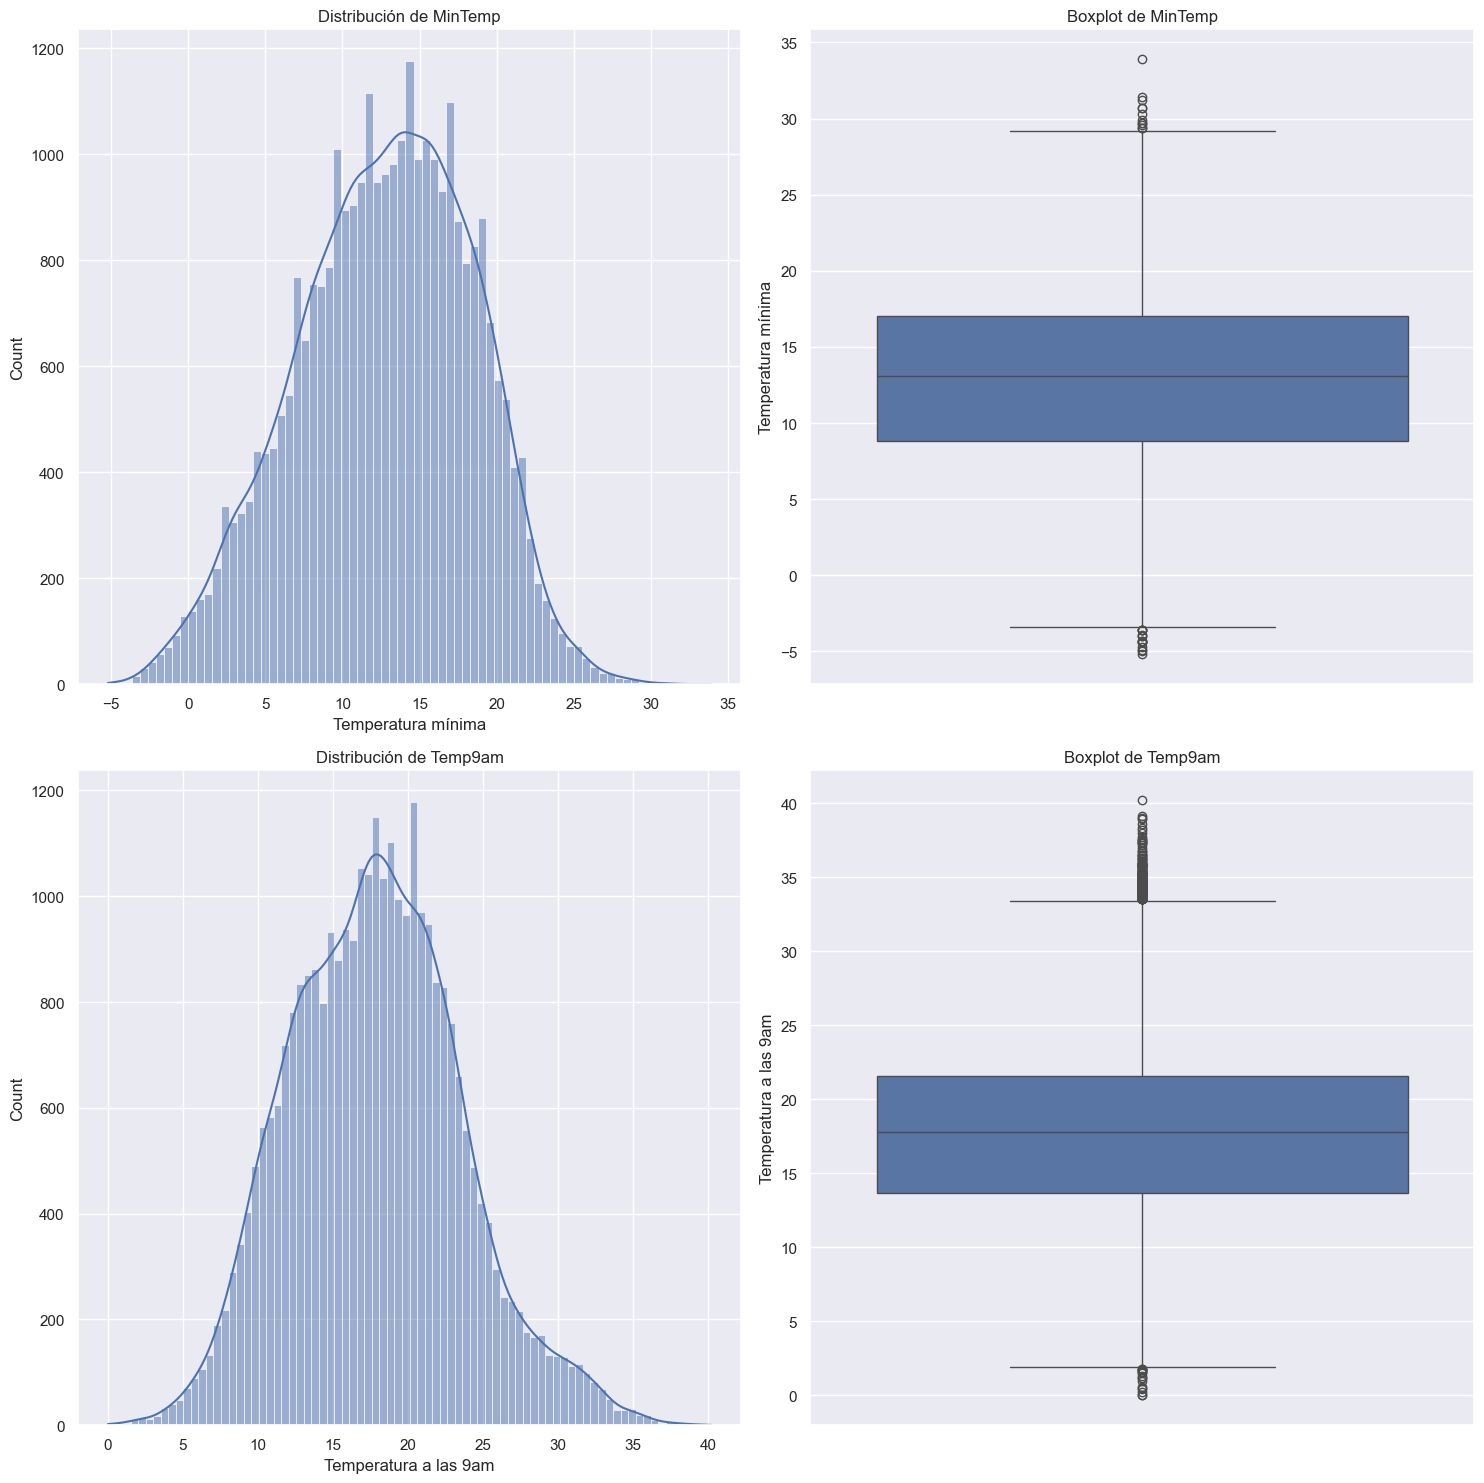

In [12]:
plt.figure(figsize=(15, 15))

# Histograma de MinTemp
plt.subplot(2, 2, 1)
sns.histplot(weatherdata['MinTemp'], kde=True)
plt.title('Distribución de MinTemp')
plt.xlabel('Temperatura mínima')

# Boxplot de MinTemp
plt.subplot(2, 2, 2)
sns.boxplot(y=weatherdata['MinTemp'])
plt.title('Boxplot de MinTemp')
plt.ylabel('Temperatura mínima')

# Histograma de Temp9am
plt.subplot(2, 2, 3)
sns.histplot(weatherdata['Temp9am'], kde=True)
plt.title('Distribución de Temp9am')
plt.xlabel('Temperatura a las 9am')

# Boxplot de Temp9am
plt.subplot(2, 2, 4)
sns.boxplot(y=weatherdata['Temp9am'])
plt.title('Boxplot de Temp9am')
plt.ylabel('Temperatura a las 9am')

plt.tight_layout()
plt.show()

## MaxTemp y Temp9am

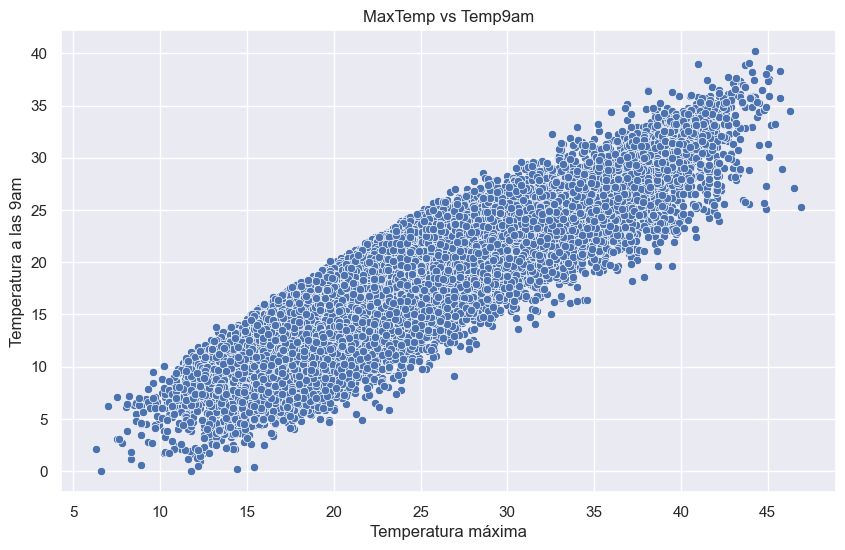

In [13]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=weatherdata, x='MaxTemp', y='Temp9am')
plt.title('MaxTemp vs Temp9am')
plt.xlabel('Temperatura máxima')
plt.ylabel('Temperatura a las 9am')
plt.show()

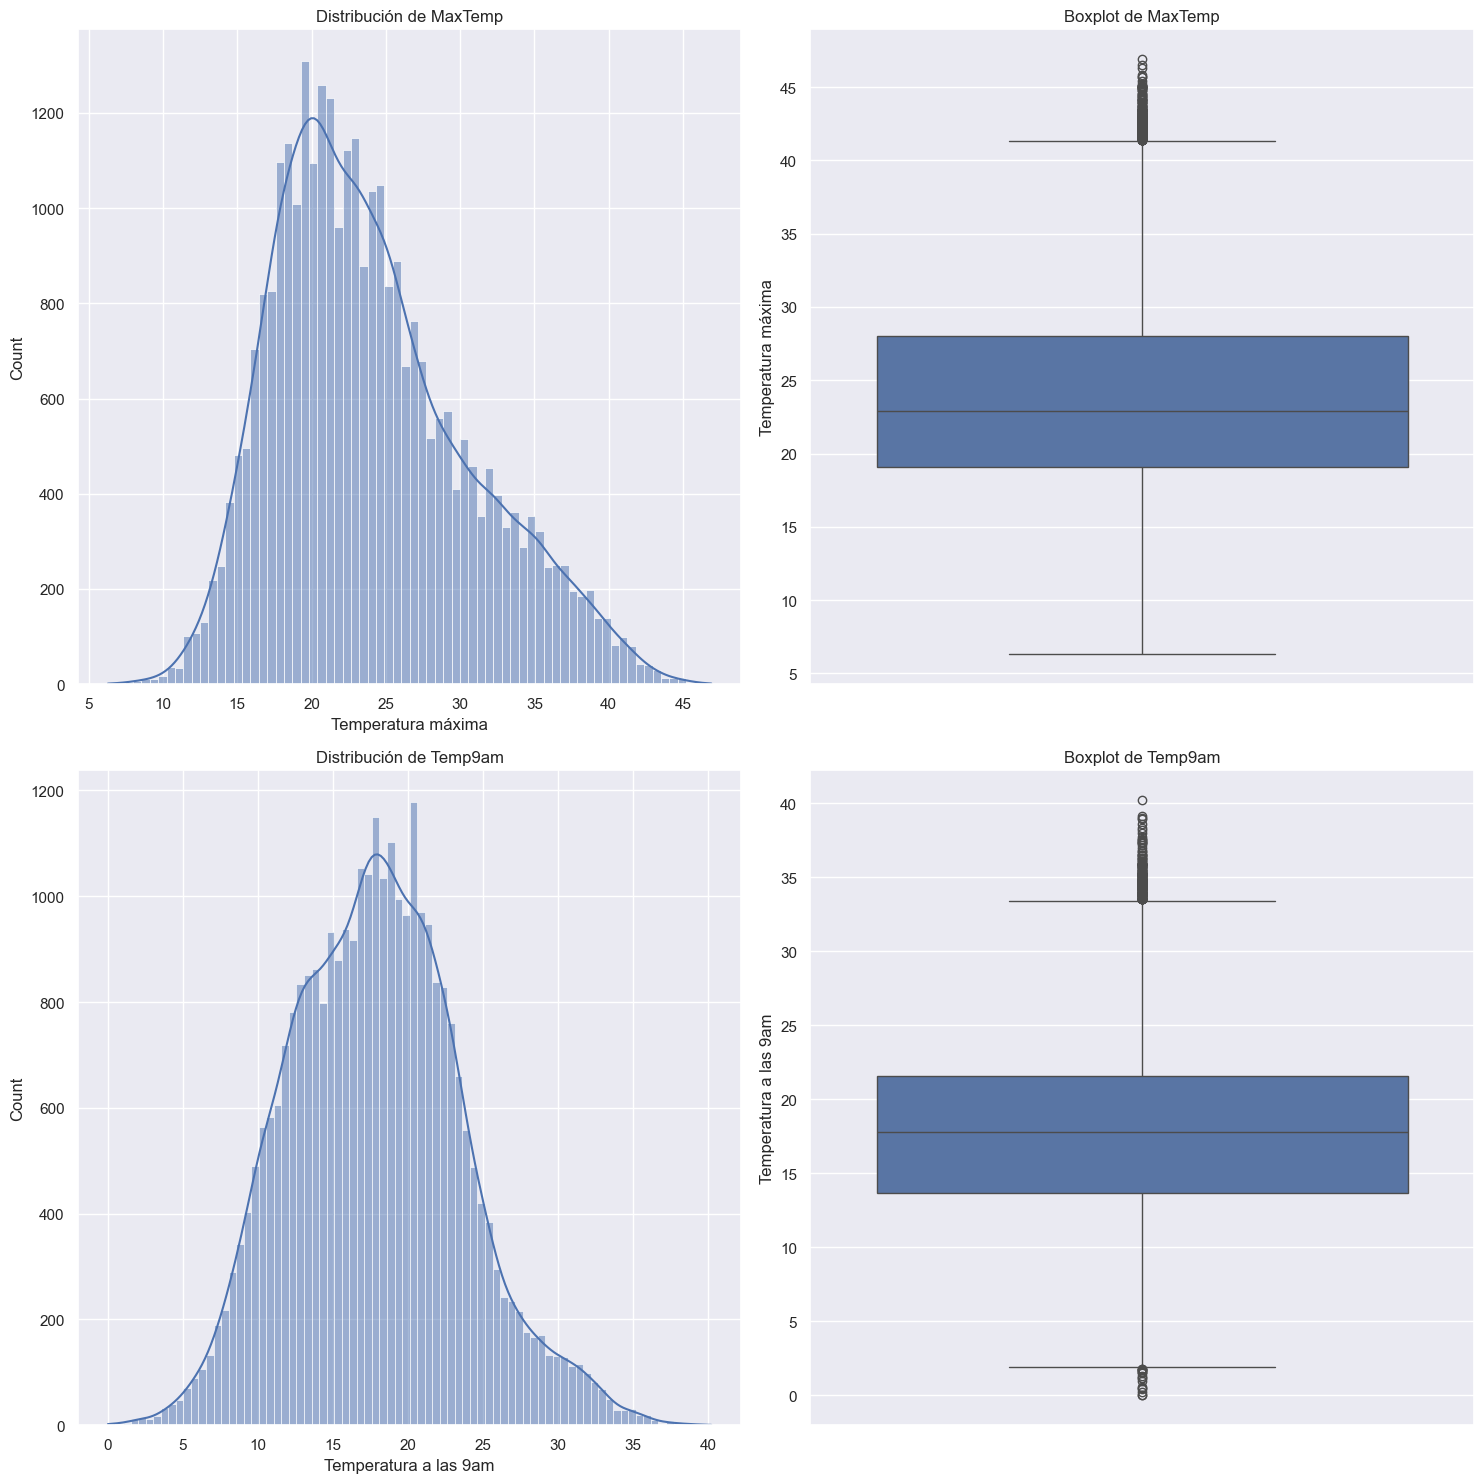

In [14]:
plt.figure(figsize=(15, 15))

# Histograma de MaxTemp
plt.subplot(2, 2, 1)
sns.histplot(weatherdata['MaxTemp'], kde=True)
plt.title('Distribución de MaxTemp')
plt.xlabel('Temperatura máxima')

# Boxplot de MaxTemp
plt.subplot(2, 2, 2)
sns.boxplot(y=weatherdata['MaxTemp'])
plt.title('Boxplot de MaxTemp')
plt.ylabel('Temperatura máxima')

# Histograma de Temp9am
plt.subplot(2, 2, 3)
sns.histplot(weatherdata['Temp9am'], kde=True)
plt.title('Distribución de Temp9am')
plt.xlabel('Temperatura a las 9am')

# Boxplot de Temp9am
plt.subplot(2, 2, 4)
sns.boxplot(y=weatherdata['Temp9am'])
plt.title('Boxplot de Temp9am')
plt.ylabel('Temperatura a las 9am')

plt.tight_layout()
plt.show()

## MaxTemp y Temp3pm

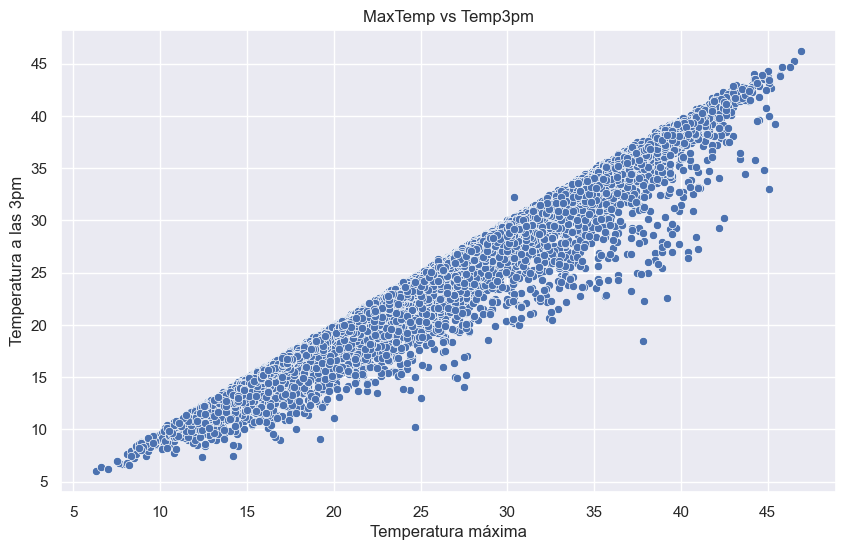

In [15]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=weatherdata, x='MaxTemp', y='Temp3pm')
plt.title('MaxTemp vs Temp3pm')
plt.xlabel('Temperatura máxima')
plt.ylabel('Temperatura a las 3pm')
plt.show()

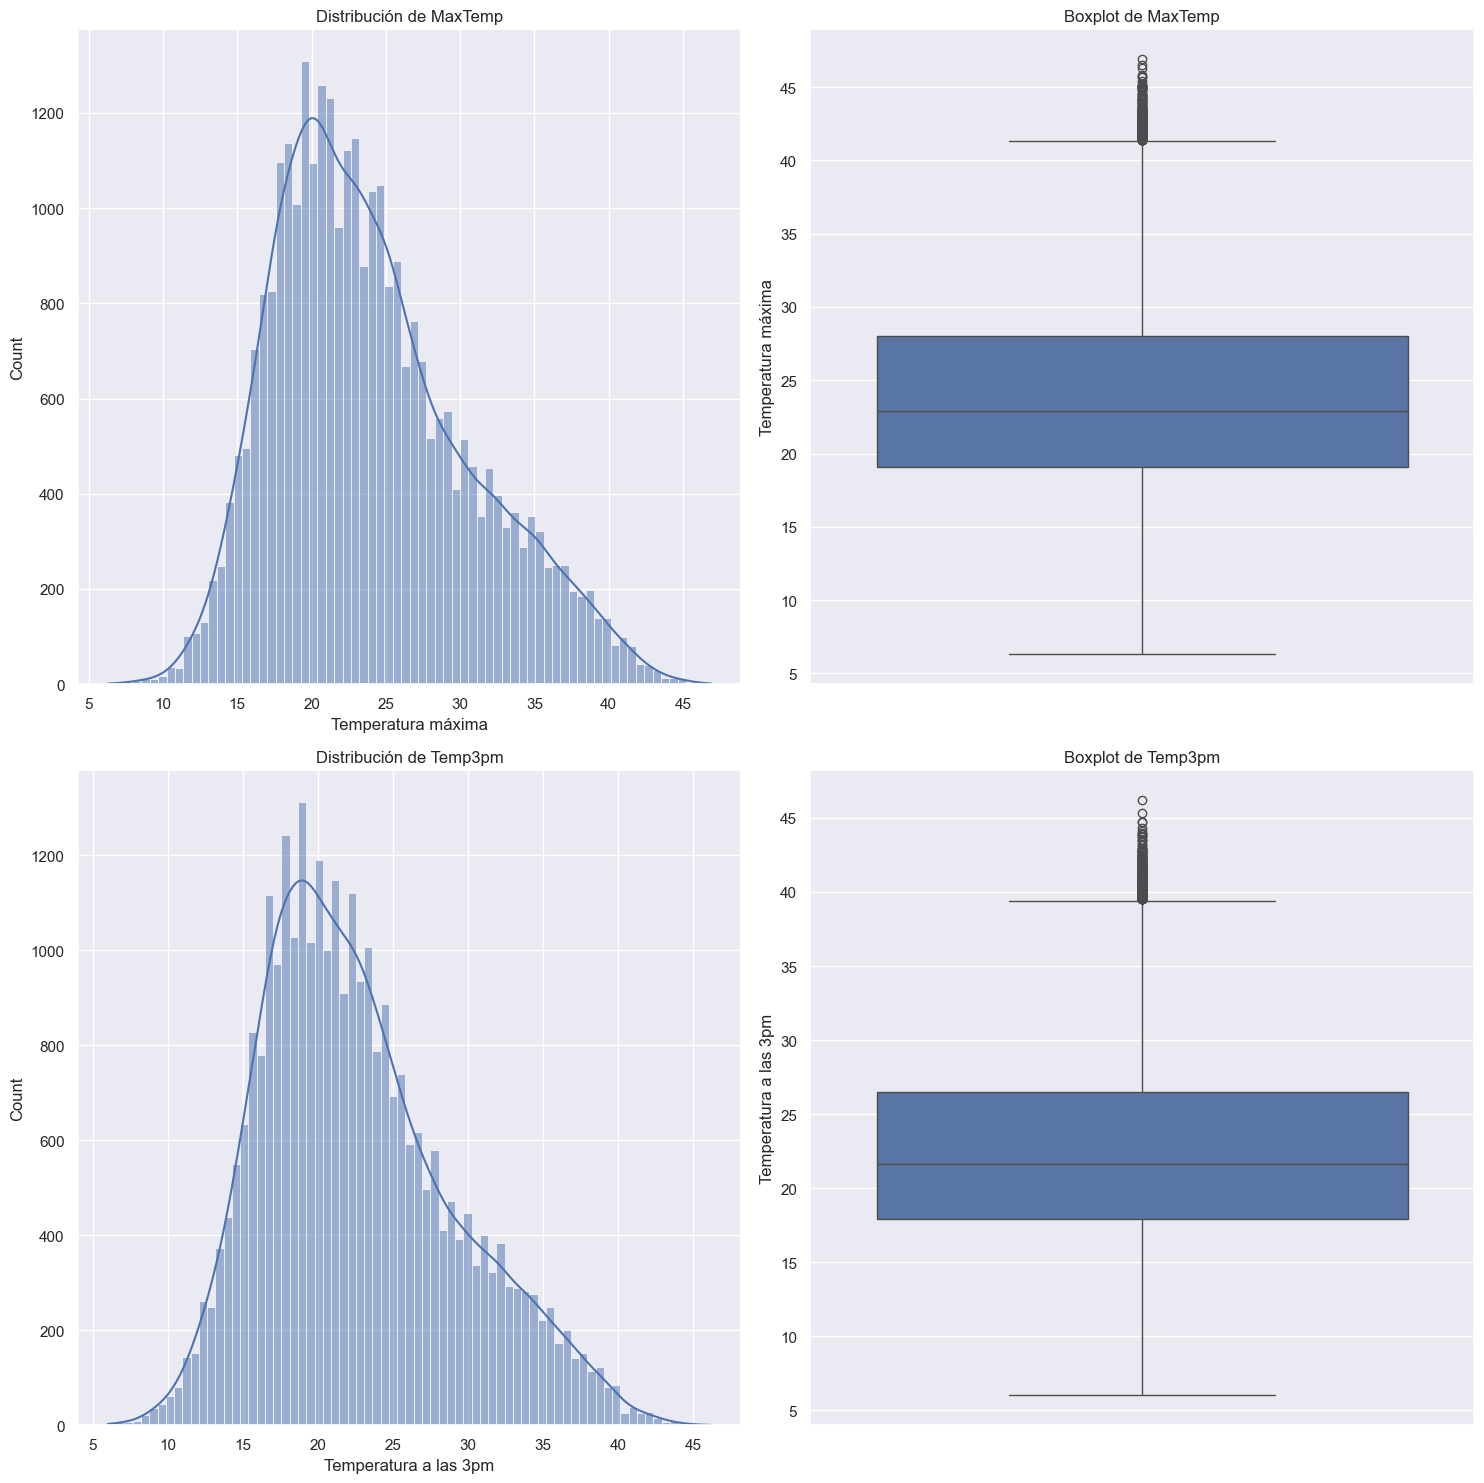

In [16]:
plt.figure(figsize=(15, 15))

# Histograma de MaxTemp
plt.subplot(2, 2, 1)
sns.histplot(weatherdata['MaxTemp'], kde=True)
plt.title('Distribución de MaxTemp')
plt.xlabel('Temperatura máxima')

# Boxplot de MaxTemp
plt.subplot(2, 2, 2)
sns.boxplot(y=weatherdata['MaxTemp'])
plt.title('Boxplot de MaxTemp')
plt.ylabel('Temperatura máxima')

# Histograma de Temp3pm
plt.subplot(2, 2, 3)
sns.histplot(weatherdata['Temp3pm'], kde=True)
plt.title('Distribución de Temp3pm')
plt.xlabel('Temperatura a las 3pm')

# Boxplot de Temp3pm
plt.subplot(2, 2, 4)
sns.boxplot(y=weatherdata['Temp3pm'])
plt.title('Boxplot de Temp3pm')
plt.ylabel('Temperatura a las 3pm')

plt.tight_layout()
plt.show()

## Temp9am y Temp3pm

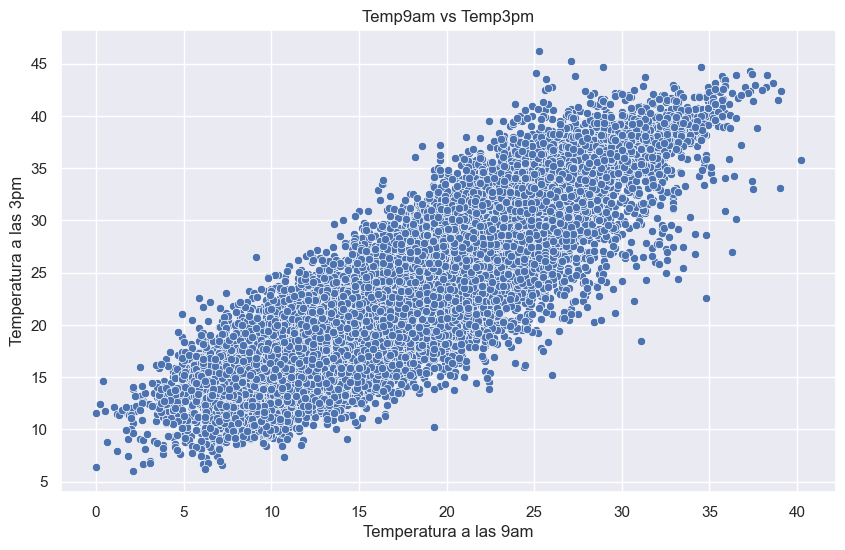

In [17]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=weatherdata, x='Temp9am', y='Temp3pm')
plt.title('Temp9am vs Temp3pm')
plt.xlabel('Temperatura a las 9am')
plt.ylabel('Temperatura a las 3pm')
plt.show()

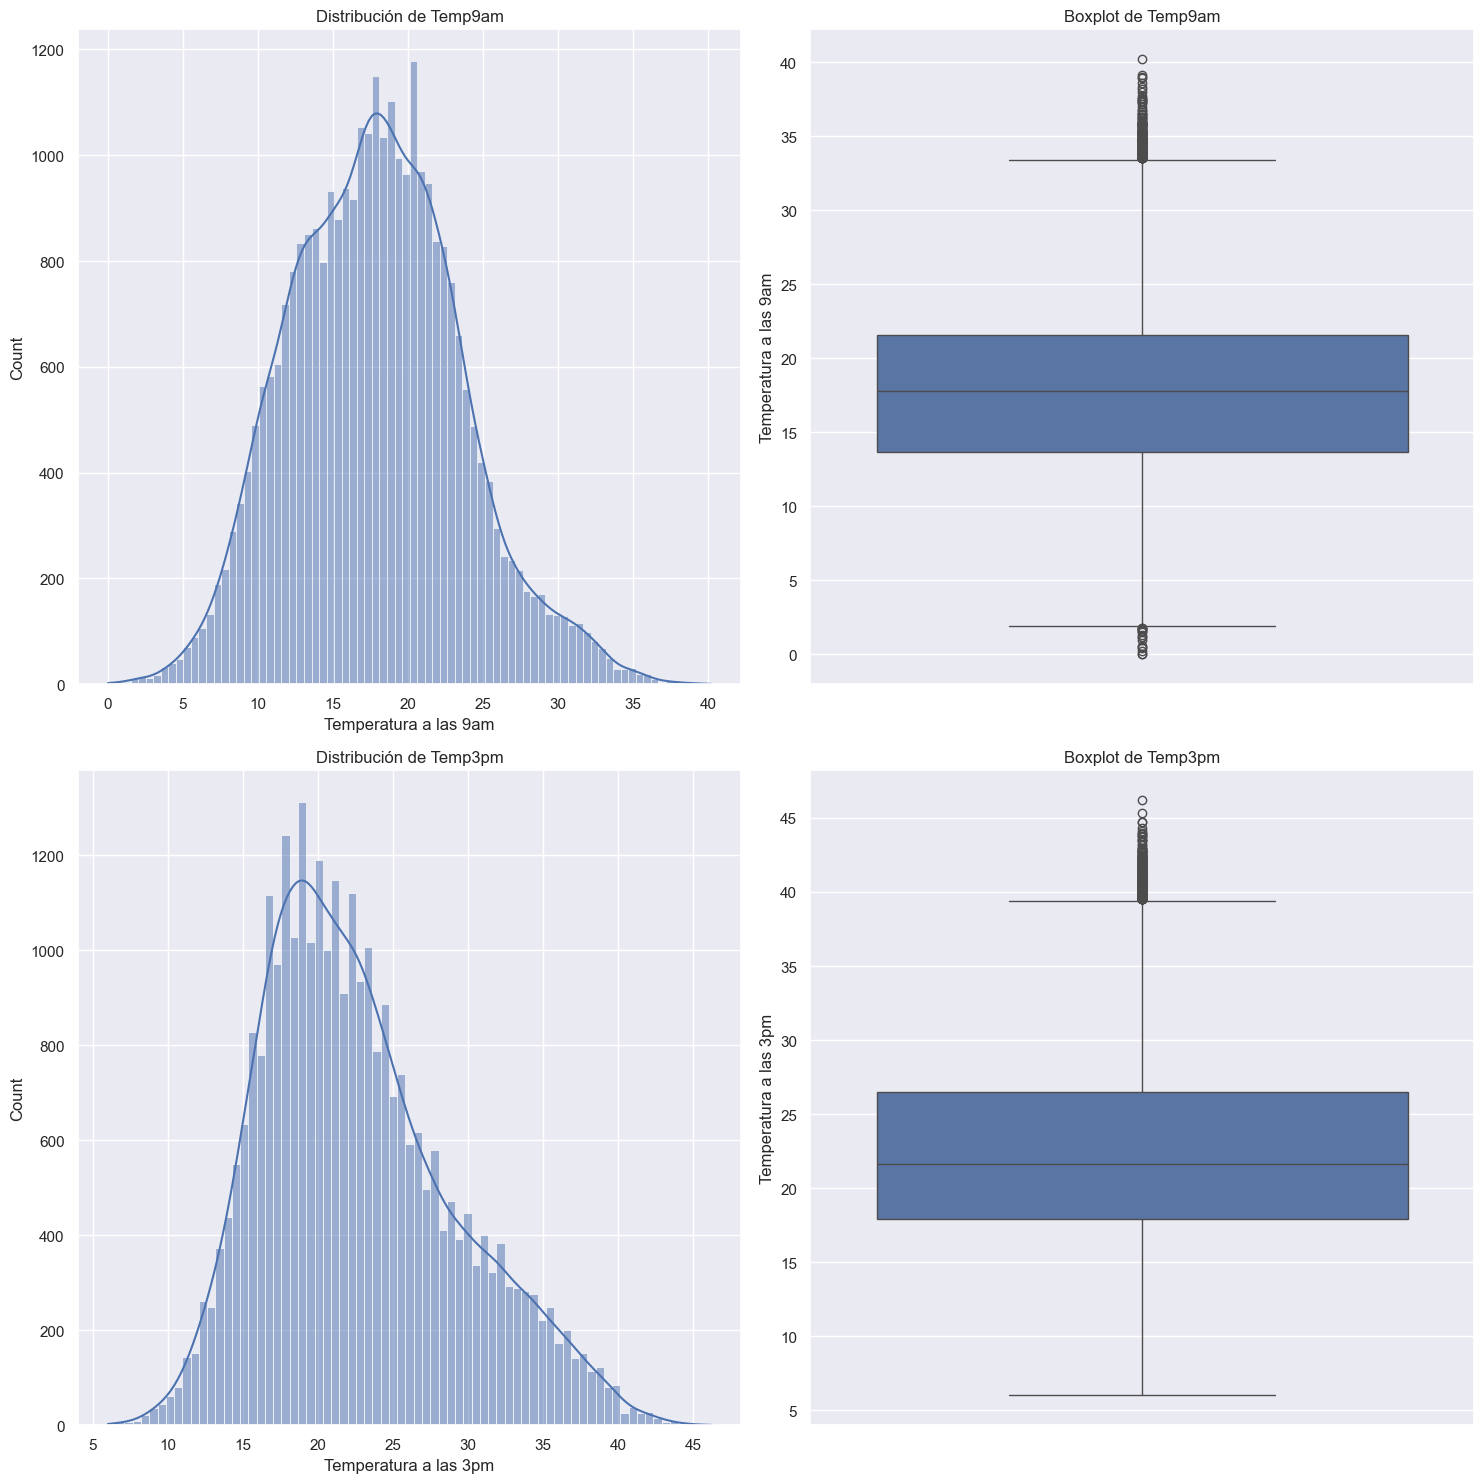

In [18]:
plt.figure(figsize=(15, 15))

# Histograma de Temp9am
plt.subplot(2, 2, 1)
sns.histplot(weatherdata['Temp9am'], kde=True)
plt.title('Distribución de Temp9am')
plt.xlabel('Temperatura a las 9am')

# Boxplot de Temp9am
plt.subplot(2, 2, 2)
sns.boxplot(y=weatherdata['Temp9am'])
plt.title('Boxplot de Temp9am')
plt.ylabel('Temperatura a las 9am')

# Histograma de Temp3pm
plt.subplot(2, 2, 3)
sns.histplot(weatherdata['Temp3pm'], kde=True)
plt.title('Distribución de Temp3pm')
plt.xlabel('Temperatura a las 3pm')

# Boxplot de Temp3pm
plt.subplot(2, 2, 4)
sns.boxplot(y=weatherdata['Temp3pm'])
plt.title('Boxplot de Temp3pm')
plt.ylabel('Temperatura a las 3pm')

plt.tight_layout()
plt.show()

## Humidity9am y Humidity3pm

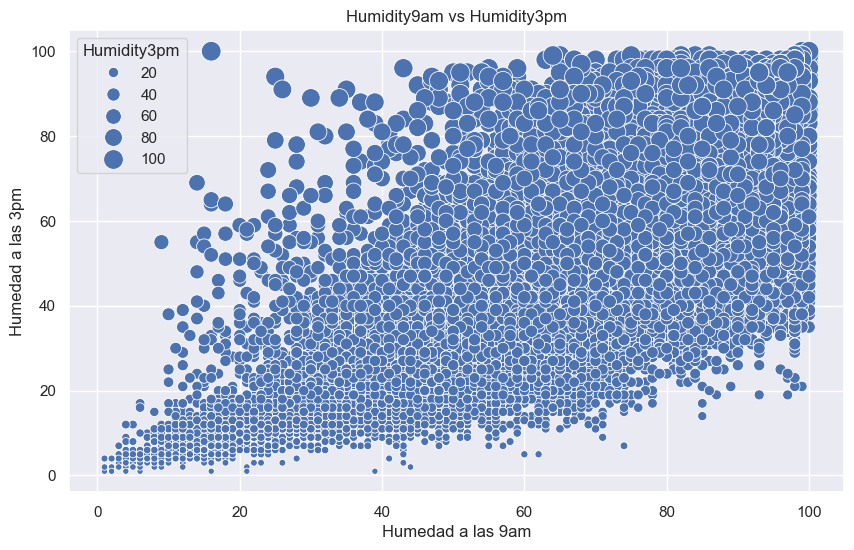

In [20]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=weatherdata, x='Humidity9am', y='Humidity3pm', size='Humidity3pm', sizes=(20, 200))
plt.title('Humidity9am vs Humidity3pm')
plt.xlabel('Humedad a las 9am')
plt.ylabel('Humedad a las 3pm')
plt.show()

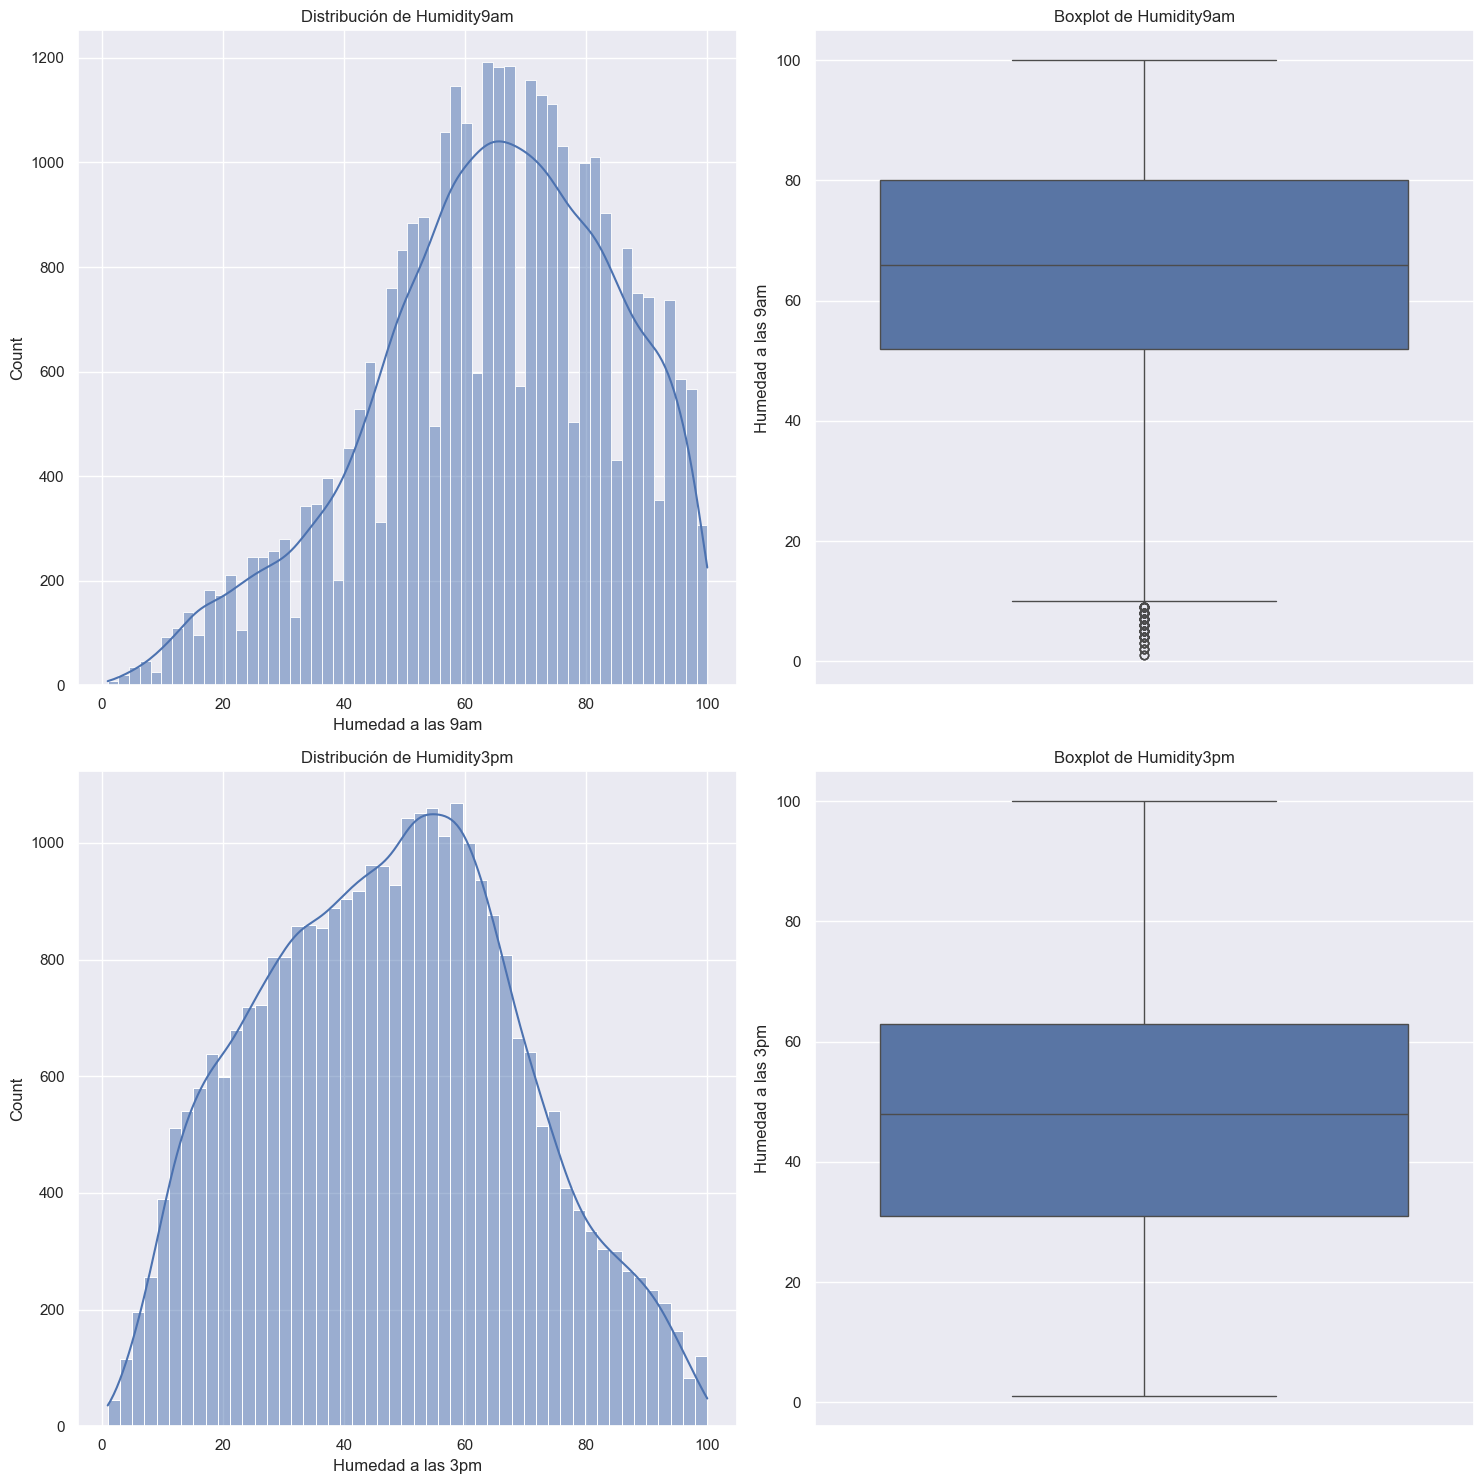

In [24]:
plt.figure(figsize=(15, 15))

# Histograma de Humidity9am
plt.subplot(2, 2, 1)
sns.histplot(weatherdata['Humidity9am'], kde=True)
plt.title('Distribución de Humidity9am')
plt.xlabel('Humedad a las 9am')

# Boxplot de Humidity9am
plt.subplot(2, 2, 2)
sns.boxplot(y=weatherdata['Humidity9am'])
plt.title('Boxplot de Humidity9am')
plt.ylabel('Humedad a las 9am')

# Histograma de Humidity3pm
plt.subplot(2, 2, 3)
sns.histplot(weatherdata['Humidity3pm'], kde=True)
plt.title('Distribución de Humidity3pm')
plt.xlabel('Humedad a las 3pm')

# Boxplot de Humidity3pm
plt.subplot(2, 2, 4)
sns.boxplot(y=weatherdata['Humidity3pm'])
plt.title('Boxplot de Humidity3pm')
plt.ylabel('Humedad a las 3pm')

plt.tight_layout()
plt.show()

## Pressure9am y Pressure3pm

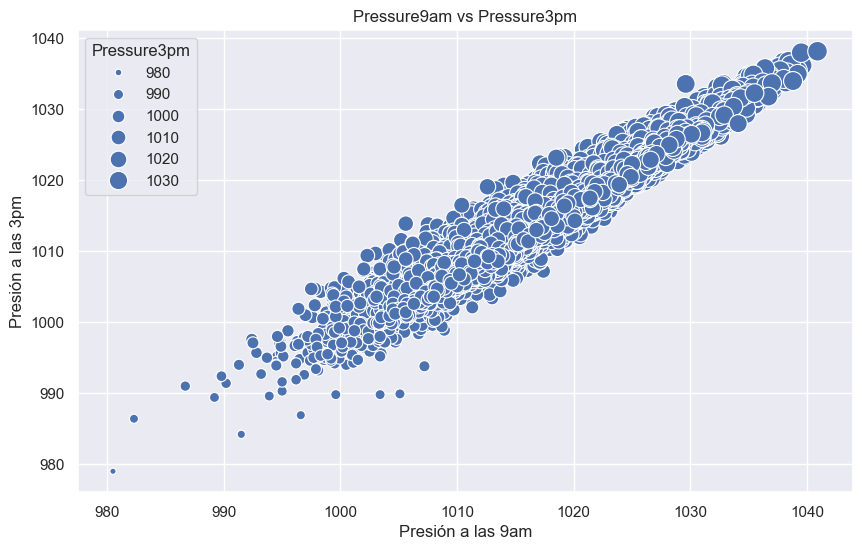

In [23]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=weatherdata, x='Pressure9am', y='Pressure3pm', size='Pressure3pm', sizes=(20, 200))
plt.title('Pressure9am vs Pressure3pm')
plt.xlabel('Presión a las 9am')
plt.ylabel('Presión a las 3pm')
plt.show()

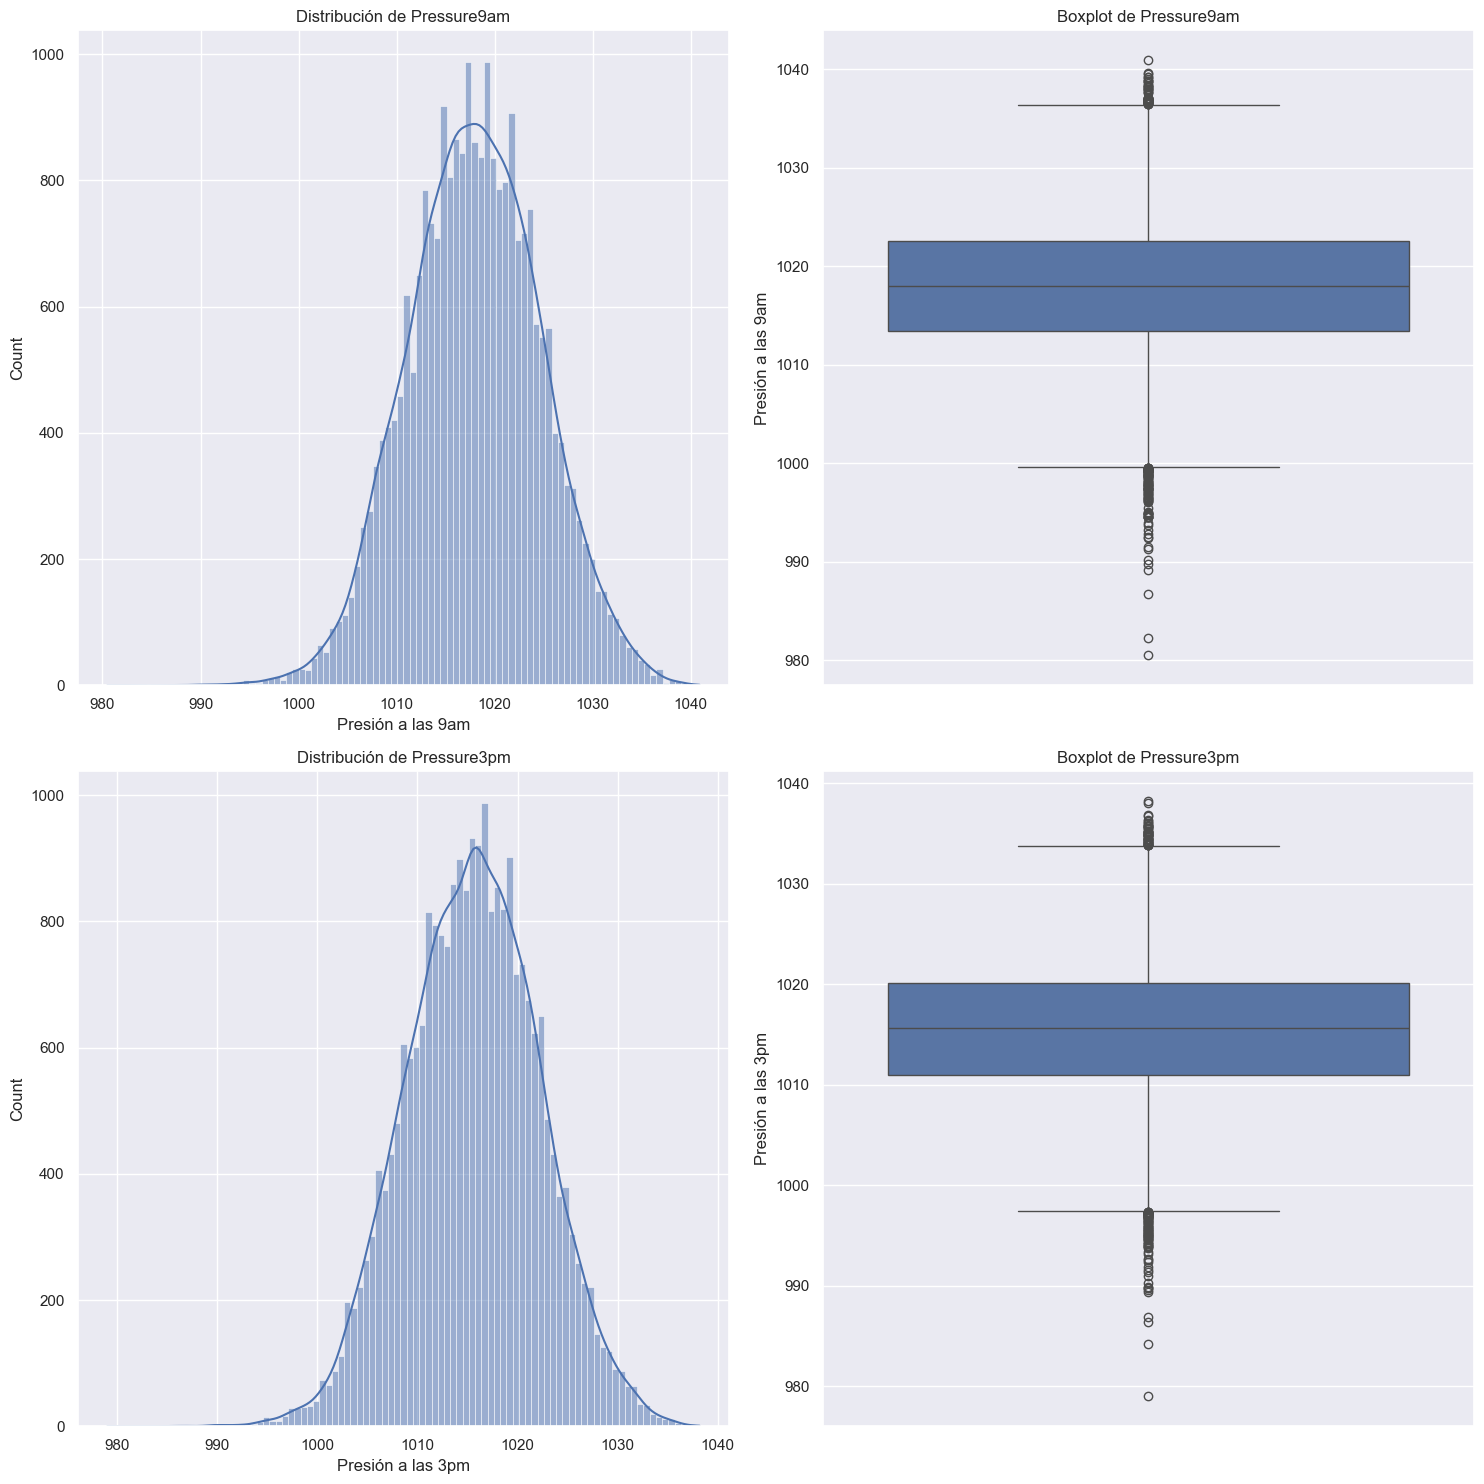

In [25]:
plt.figure(figsize=(15, 15))

# Histograma de Pressure9am
plt.subplot(2, 2, 1)
sns.histplot(weatherdata['Pressure9am'], kde=True)
plt.title('Distribución de Pressure9am')
plt.xlabel('Presión a las 9am')

# Boxplot de Pressure9am
plt.subplot(2, 2, 2)
sns.boxplot(y=weatherdata['Pressure9am'])
plt.title('Boxplot de Pressure9am')
plt.ylabel('Presión a las 9am')

# Histograma de Pressure3pm
plt.subplot(2, 2, 3)
sns.histplot(weatherdata['Pressure3pm'], kde=True)
plt.title('Distribución de Pressure3pm')
plt.xlabel('Presión a las 3pm')

# Boxplot de Pressure3pm
plt.subplot(2, 2, 4)
sns.boxplot(y=weatherdata['Pressure3pm'])
plt.title('Boxplot de Pressure3pm')
plt.ylabel('Presión a las 3pm')

plt.tight_layout()
plt.show()

VERRRRR

## Sunshine, Cloud9am y Cloud3pm

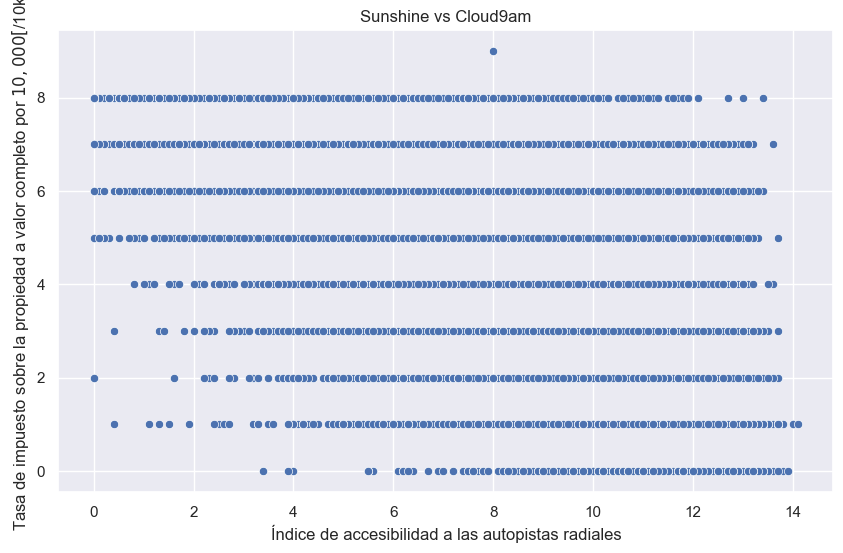

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=weatherdata, x='Sunshine', y='Cloud9am')
plt.title('Sunshine vs Cloud9am')
plt.xlabel('Índice de accesibilidad a las autopistas radiales')
plt.ylabel('Tasa de impuesto sobre la propiedad a valor completo por $10,000 [$/10k]')
plt.show()

In [ ]:
plt.figure(figsize=(15, 15))

# Histograma de AGE
plt.subplot(2, 2, 1)
sns.histplot(weatherdata['RAD'], kde=True)
plt.title('Distribución de RAD')
plt.xlabel('Índice de accesibilidad a las autopistas radiales')

# Boxplot de AGE
plt.subplot(2, 2, 2)
sns.boxplot(y=weatherdata['RAD'])
plt.title('Boxplot de RAD')
plt.ylabel('Índice de accesibilidad a las autopistas radiales')

# Histograma de DIS
plt.subplot(2, 2, 3)
sns.histplot(weatherdata['TAX'], kde=True)
plt.title('Distribución de TAX')
plt.xlabel('Tasa de impuesto sobre la propiedad a valor completo por $10,000 [$/10k]')

# Boxplot de DIS
plt.subplot(2, 2, 4)
sns.boxplot(y=weatherdata['TAX'])
plt.title('Boxplot de TAX')
plt.ylabel('Tasa de impuesto sobre la propiedad a valor completo por $10,000 [$/10k]')

plt.tight_layout()
plt.show()

In [ ]:
# 1. Gráfico de dispersión 3D
fig = px.scatter_3d(weatherdata, x='AGE', y='DIS', z='MEDV', color='MEDV',
                    title='Relación entre AGE, DIS contra MEDV',
                    labels={'MEDV': 'Valor mediano de las viviendas', 
                            'AGE': 'AGE',
                            'DIS': 'DIS'})
fig.show()

## Rainfall

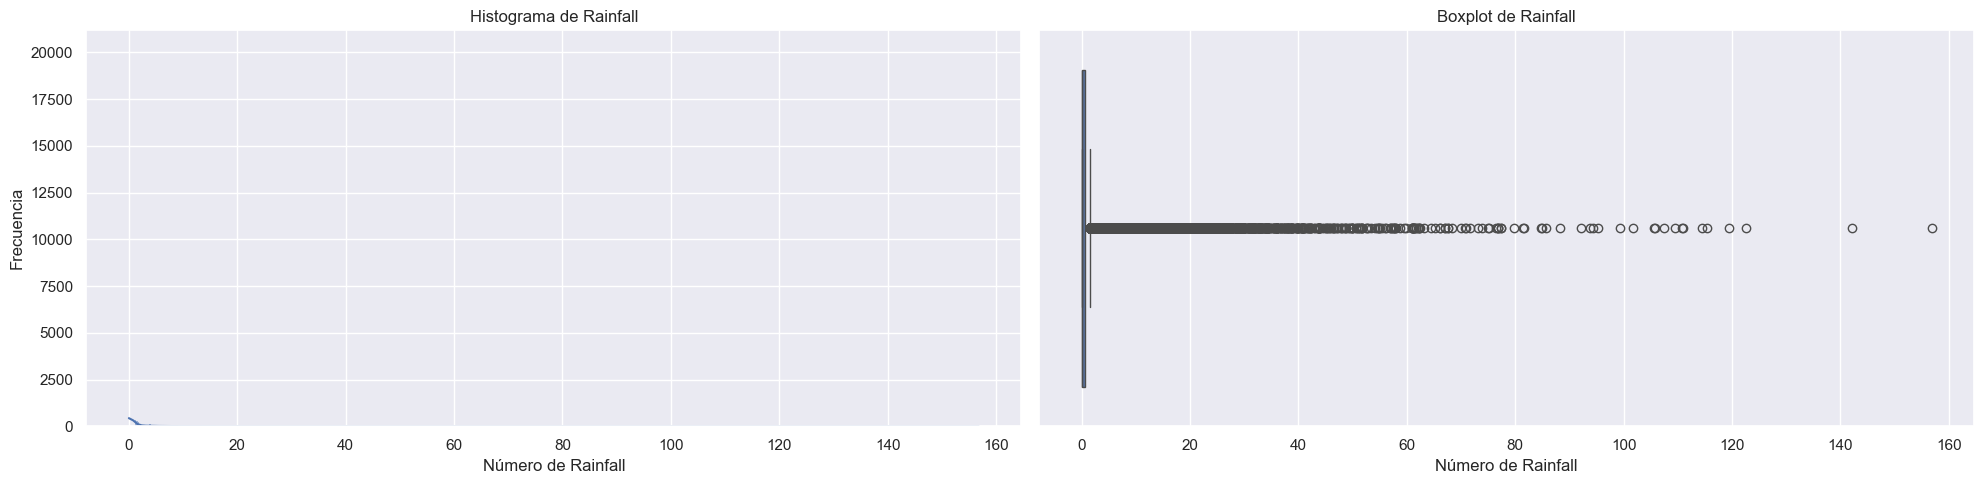

count    30290.000000
mean         1.980865
std          6.577661
min          0.000000
25%          0.000000
50%          0.000000
75%          0.600000
max        156.800000
Name: Rainfall, dtype: float64

In [26]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

# Histograma
sns.histplot(weatherdata['Rainfall'], kde=True, ax=axs[0])
axs[0].set_title('Histograma de Rainfall')
axs[0].set_xlabel('Número de Rainfall')
axs[0].set_ylabel('Frecuencia')

# Calcular cuartiles 
q1 = weatherdata['Rainfall'].quantile(0.25)
q2 = weatherdata['Rainfall'].quantile(0.5)
q3 = weatherdata['Rainfall'].quantile(0.75)

# Boxplot
sns.boxplot(x=weatherdata['Rainfall'], ax=axs[1])
axs[1].set_title('Boxplot de Rainfall')
axs[1].set_xlabel('Número de Rainfall')

plt.tight_layout()
plt.show()

weatherdata['Rainfall'].describe()

## Evaporation

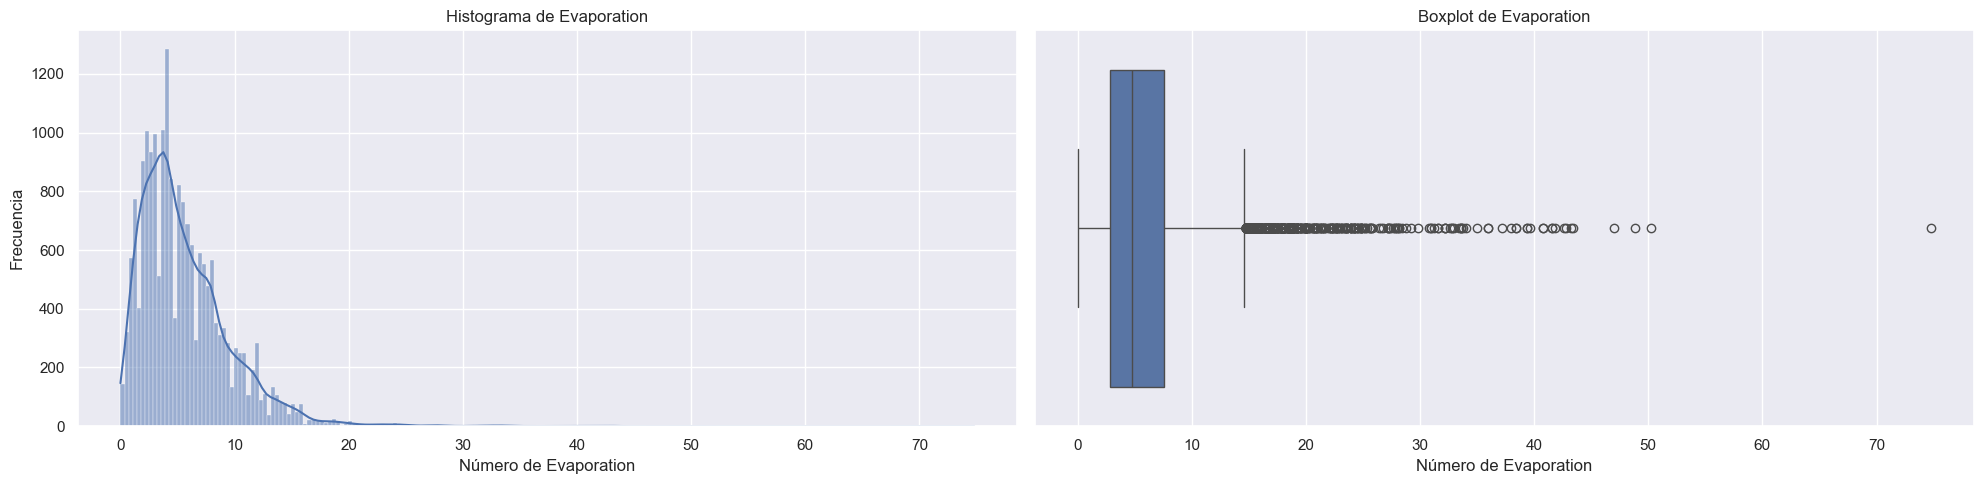

count    19410.000000
mean         5.663776
std          4.131155
min          0.000000
25%          2.800000
50%          4.800000
75%          7.600000
max         74.800000
Name: Evaporation, dtype: float64

In [27]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

# Histograma
sns.histplot(weatherdata['Evaporation'], kde=True, ax=axs[0])
axs[0].set_title('Histograma de Evaporation')
axs[0].set_xlabel('Número de Evaporation')
axs[0].set_ylabel('Frecuencia')

# Calcular cuartiles 
q1 = weatherdata['Evaporation'].quantile(0.25)
q2 = weatherdata['Evaporation'].quantile(0.5)
q3 = weatherdata['Evaporation'].quantile(0.75)

# Boxplot
sns.boxplot(x=weatherdata['Evaporation'], ax=axs[1])
axs[1].set_title('Boxplot de Evaporation')
axs[1].set_xlabel('Número de Evaporation')

plt.tight_layout()
plt.show()

weatherdata['Evaporation'].describe()

## WindGustSpeed

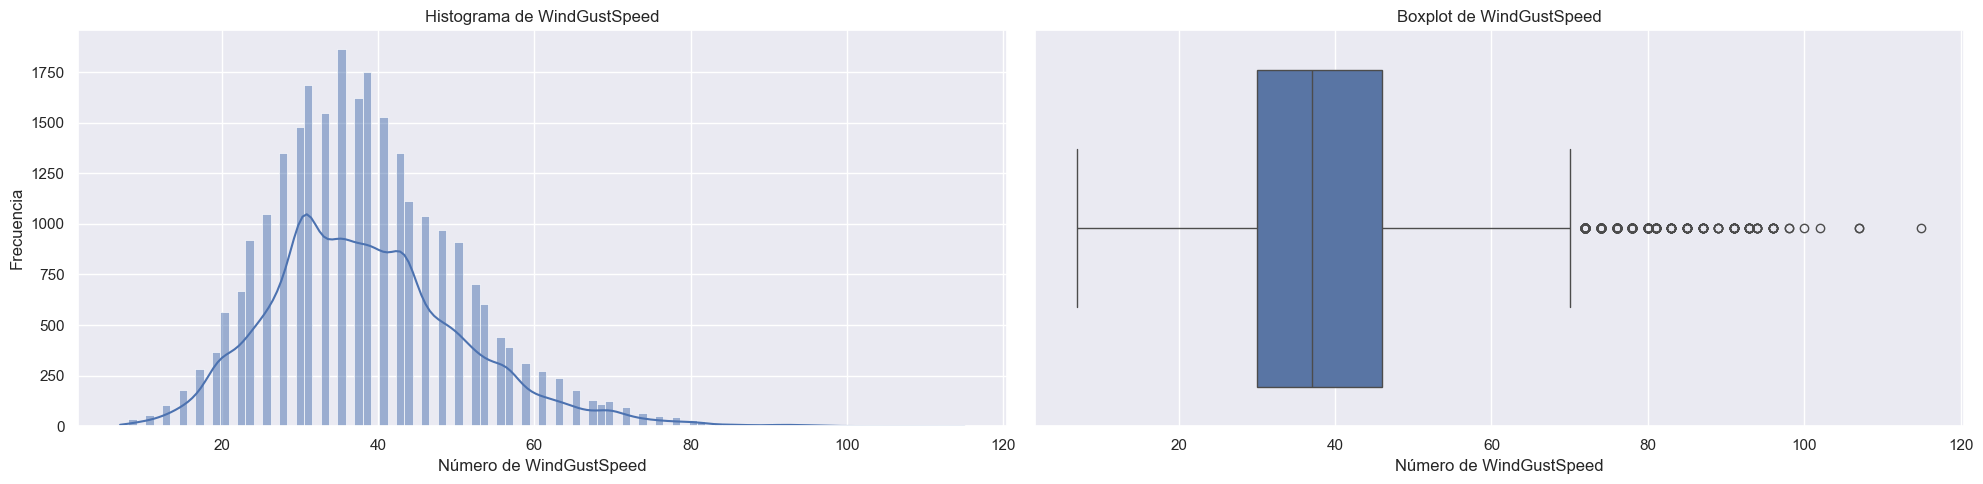

count    26351.000000
mean        38.525065
std         12.460749
min          7.000000
25%         30.000000
50%         37.000000
75%         46.000000
max        115.000000
Name: WindGustSpeed, dtype: float64

In [28]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

# Histograma
sns.histplot(weatherdata['WindGustSpeed'], kde=True, ax=axs[0])
axs[0].set_title('Histograma de WindGustSpeed')
axs[0].set_xlabel('Número de WindGustSpeed')
axs[0].set_ylabel('Frecuencia')

# Calcular cuartiles 
q1 = weatherdata['WindGustSpeed'].quantile(0.25)
q2 = weatherdata['WindGustSpeed'].quantile(0.5)
q3 = weatherdata['WindGustSpeed'].quantile(0.75)

# Boxplot
sns.boxplot(x=weatherdata['WindGustSpeed'], ax=axs[1])
axs[1].set_title('Boxplot de WindGustSpeed')
axs[1].set_xlabel('Número de WindGustSpeed')

plt.tight_layout()
plt.show()

weatherdata['WindGustSpeed'].describe()

## WindSpeed9am

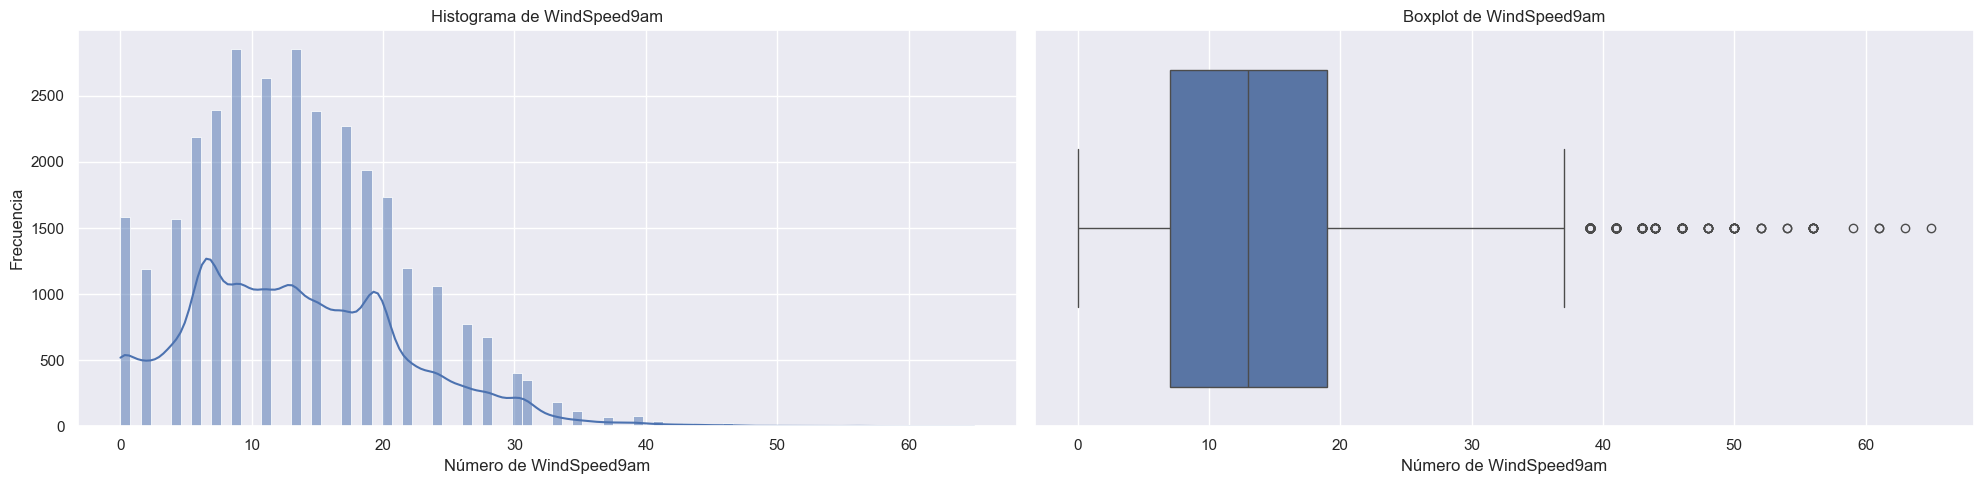

count    30641.000000
mean        13.440129
std          8.257208
min          0.000000
25%          7.000000
50%         13.000000
75%         19.000000
max         65.000000
Name: WindSpeed9am, dtype: float64

In [29]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

# Histograma
sns.histplot(weatherdata['WindSpeed9am'], kde=True, ax=axs[0])
axs[0].set_title('Histograma de WindSpeed9am')
axs[0].set_xlabel('Número de WindSpeed9am')
axs[0].set_ylabel('Frecuencia')

# Calcular cuartiles 
q1 = weatherdata['WindSpeed9am'].quantile(0.25)
q2 = weatherdata['WindSpeed9am'].quantile(0.5)
q3 = weatherdata['WindSpeed9am'].quantile(0.75)

# Boxplot
sns.boxplot(x=weatherdata['WindSpeed9am'], ax=axs[1])
axs[1].set_title('Boxplot de WindSpeed9am')
axs[1].set_xlabel('Número de WindSpeed9am')

plt.tight_layout()
plt.show()

weatherdata['WindSpeed9am'].describe()

## WindSpeed3pm

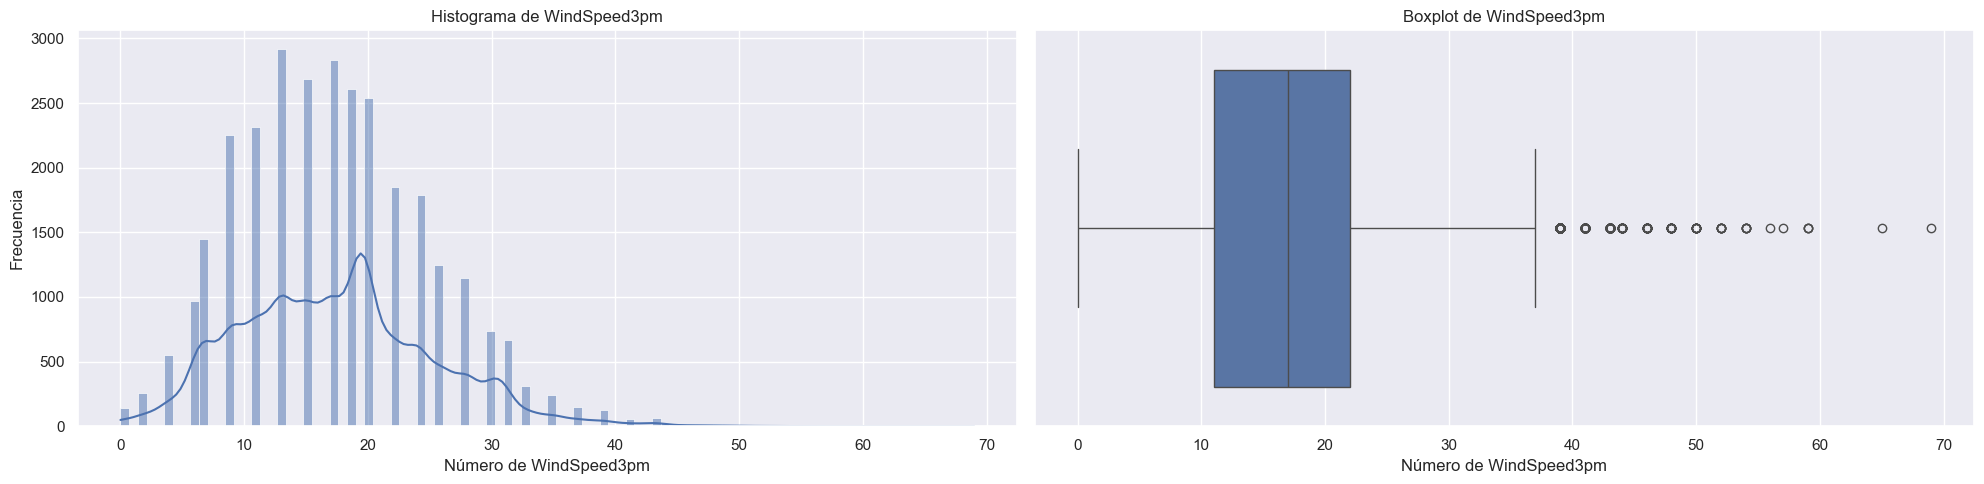

count    29991.000000
mean        17.361042
std          7.832646
min          0.000000
25%         11.000000
50%         17.000000
75%         22.000000
max         69.000000
Name: WindSpeed3pm, dtype: float64

In [30]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

# Histograma
sns.histplot(weatherdata['WindSpeed3pm'], kde=True, ax=axs[0])
axs[0].set_title('Histograma de WindSpeed3pm')
axs[0].set_xlabel('Número de WindSpeed3pm')
axs[0].set_ylabel('Frecuencia')

# Calcular cuartiles 
q1 = weatherdata['WindSpeed3pm'].quantile(0.25)
q2 = weatherdata['WindSpeed3pm'].quantile(0.5)
q3 = weatherdata['WindSpeed3pm'].quantile(0.75)

# Boxplot
sns.boxplot(x=weatherdata['WindSpeed3pm'], ax=axs[1])
axs[1].set_title('Boxplot de WindSpeed3pm')
axs[1].set_xlabel('Número de WindSpeed3pm')

plt.tight_layout()
plt.show()

weatherdata['WindSpeed3pm'].describe()

## WindGustDir

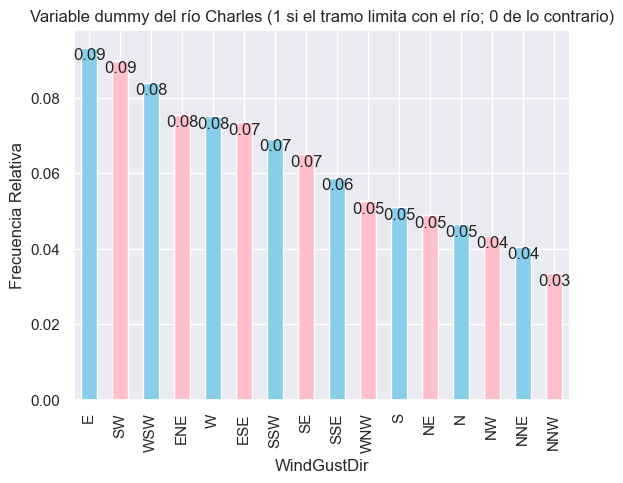

In [31]:
# GRÁFICO PARA VISUALIZAR EL BALANCE DE 'WindGustDir'
rel_freq = weatherdata['WindGustDir'].value_counts(normalize=True)

grafico = rel_freq.plot(kind='bar', color=['skyblue', 'pink'])

plt.title('Variable dummy del río Charles (1 si el tramo limita con el río; 0 de lo contrario)')
plt.ylabel('Frecuencia Relativa')

for index, value in enumerate(rel_freq):
    plt.text(index, value, f'{value:.2f}', ha='center', va='top')

plt.show()

## WindDir9am

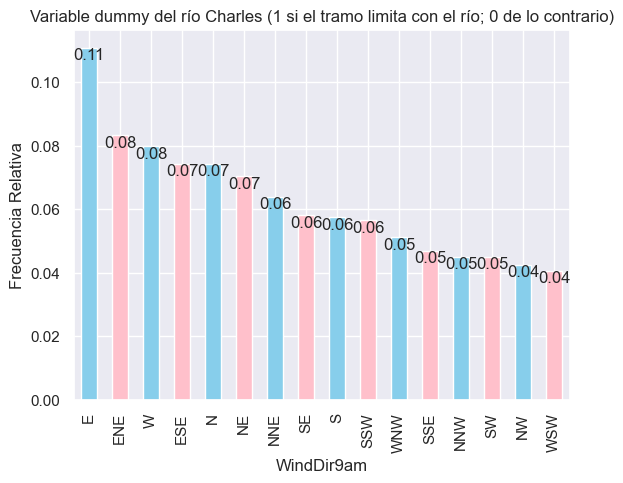

In [32]:
# GRÁFICO PARA VISUALIZAR EL BALANCE DE 'WindDir9am'
rel_freq = weatherdata['WindDir9am'].value_counts(normalize=True)

grafico = rel_freq.plot(kind='bar', color=['skyblue', 'pink'])

plt.title('Variable dummy del río Charles (1 si el tramo limita con el río; 0 de lo contrario)')
plt.ylabel('Frecuencia Relativa')

for index, value in enumerate(rel_freq):
    plt.text(index, value, f'{value:.2f}', ha='center', va='top')

plt.show()

## WindDir3pm

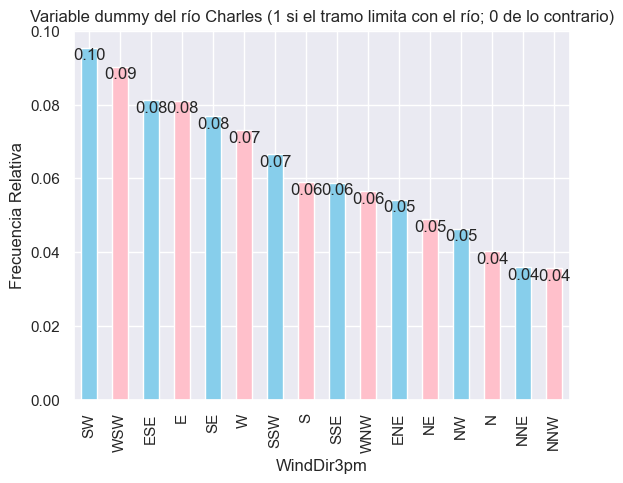

In [33]:
# GRÁFICO PARA VISUALIZAR EL BALANCE DE 'RainTomorrow'
rel_freq = weatherdata['WindDir3pm'].value_counts(normalize=True)

grafico = rel_freq.plot(kind='bar', color=['skyblue', 'pink'])

plt.title('Variable dummy del río Charles (1 si el tramo limita con el río; 0 de lo contrario)')
plt.ylabel('Frecuencia Relativa')

for index, value in enumerate(rel_freq):
    plt.text(index, value, f'{value:.2f}', ha='center', va='top')

plt.show()

## RainToday

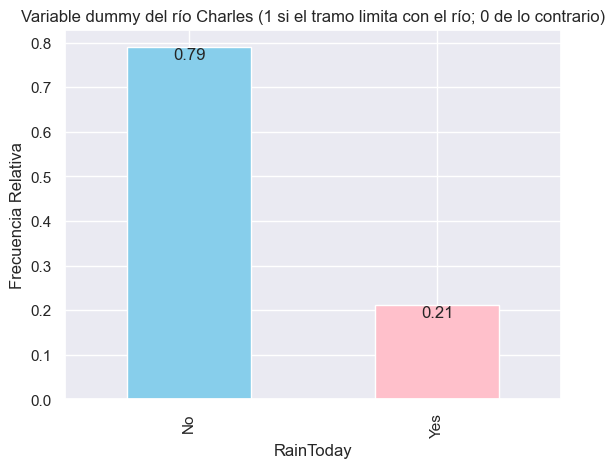

In [34]:
# GRÁFICO PARA VISUALIZAR EL BALANCE DE 'RainToday'
rel_freq = weatherdata['RainToday'].value_counts(normalize=True)

grafico = rel_freq.plot(kind='bar', color=['skyblue', 'pink'])

plt.title('Variable dummy del río Charles (1 si el tramo limita con el río; 0 de lo contrario)')
plt.ylabel('Frecuencia Relativa')

for index, value in enumerate(rel_freq):
    plt.text(index, value, f'{value:.2f}', ha='center', va='top')

plt.show()

## RainTomorrow

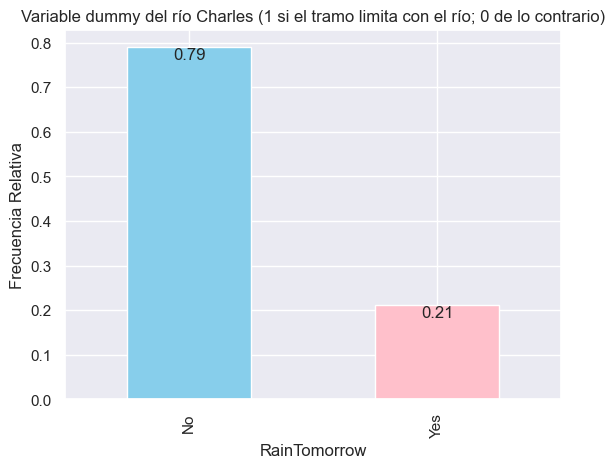

In [35]:
# GRÁFICO PARA VISUALIZAR EL BALANCE DE 'RainTomorrow'
rel_freq = weatherdata['RainTomorrow'].value_counts(normalize=True)

grafico = rel_freq.plot(kind='bar', color=['skyblue', 'pink'])

plt.title('Variable dummy del río Charles (1 si el tramo limita con el río; 0 de lo contrario)')
plt.ylabel('Frecuencia Relativa')

for index, value in enumerate(rel_freq):
    plt.text(index, value, f'{value:.2f}', ha='center', va='top')

plt.show()

## Matriz de correlación de variable categoricas